In [1]:
# Importação as bibliotecas necessárias para conexão e coleta dos dados
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os

In [2]:
# Variaveis ambientes

host = os.environ.get('HOST_POSTGRE')
user = os.environ.get('USER_POSTGRE')
password = os.environ.get('PASSWORD_POSTGRE')

In [3]:
# Descrevo os parâmetros de conexão conforme configurado
db_server_info = {'host': host, 
                  'porta': 5432, 
                  'dbname': 'dbs_vacina',
                  'user': user, 
                  'password': password} 

conn_str = '{}://{}:{}@{}:{}/{}'.format('postgresql+psycopg2', 
                                  db_server_info['user'], 
                                  db_server_info['password'], 
                                  db_server_info['host'], 
                                  db_server_info['porta'], 
                                  db_server_info['dbname']) 

alchemyEngine = create_engine(conn_str, pool_recycle=3600)

postgreSQLConnection = alchemyEngine.connect() 

In [4]:
# Encontrando o id relacionado ao Distrito Federal

pd.read_sql_query("SELECT * FROM public.tbl_cidade WHERE uf = 'DF'", postgreSQLConnection)

,id,nm_municipio,uf,lat,lon,cd_ibge_reduzido
0,5300108,Brasília,DF,-15.8049,-47.88683,530010


In [5]:
# Dataframe de CEPs do DF

dfCepsDF = pd.read_sql_query("SELECT * FROM public.tbl_cep WHERE cidade_id = 5300108", postgreSQLConnection)
dfCepsDF.head()

,id,cep,cidade_id,lat,lon
0,18098,70002,5300108,-47.879545,-15.790642
1,18099,70003,5300108,-47.880634,-15.790649
2,18100,70037,5300108,-47.882790,-15.805816
3,18101,70040,5300108,-47.884265,-15.791226
4,18102,70041,5300108,-47.881478,-15.788280


In [6]:
# Dataframe de Estabelecimentos de Saúde do DF

ceps = dfCepsDF.id

dfEstab = pd.read_sql_query("SELECT * FROM public.tbl_estabelecimento", postgreSQLConnection)

dfEstabDF = dfEstab.loc[dfEstab['id_cep'].isin(ceps)].copy()
dfEstabDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,id_tipo_estabelecimento,id_atividade_principal,lat,lon
300620,3937399,MARIA DO CARMO PINHEIRO,MARIA DO CARMO PINHEIRO,18125.0,4000.0,NaN,NaN,NaN,NaN
300686,3263398,PERIOCENTRO ODONTOLOGIA LTDA,PERIOCENTRO,18132.0,2000.0,NaN,NaN,NaN,NaN
300816,3025411,CENTRO CLINICO SANTO EXPEDITO LTDA,CLINICAR,18144.0,2000.0,NaN,NaN,NaN,NaN
301540,788740,AVALIAR DIGNOSTICO LTDA,AVALIAR DIAGNOSTICO,18150.0,2062.0,16.0,1.0,NaN,NaN
301612,5078962,DENTE CROSS LTDA,DENTE CROSS,18190.0,2000.0,NaN,NaN,NaN,NaN


In [7]:
# Quantidade de estabelecimentos de saúde no DF

dfEstabDF.shape

(8815, 9)

In [8]:
# Informações gerais do dataframe de estabelecimentos de saúde do DF

dfEstabDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8815 entries, 300620 to 312262
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       8815 non-null   int64  
 1   nm_razao_social          8815 non-null   object 
 2   nm_fantasia              8815 non-null   object 
 3   id_cep                   8815 non-null   float64
 4   id_natureza_juridica     8815 non-null   float64
 5   id_tipo_estabelecimento  4596 non-null   float64
 6   id_atividade_principal   4596 non-null   float64
 7   lat                      0 non-null      float64
 8   lon                      0 non-null      float64
dtypes: float64(6), int64(1), object(2)
memory usage: 688.7+ KB


In [9]:
# Dropando colunas com muitos valores ausentes

dfEstabDF.drop(columns = ['id_tipo_estabelecimento','id_atividade_principal','lat','lon'],axis=1,inplace=True)
dfEstabDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica
300620,3937399,MARIA DO CARMO PINHEIRO,MARIA DO CARMO PINHEIRO,18125.0,4000.0
300686,3263398,PERIOCENTRO ODONTOLOGIA LTDA,PERIOCENTRO,18132.0,2000.0
300816,3025411,CENTRO CLINICO SANTO EXPEDITO LTDA,CLINICAR,18144.0,2000.0
301540,788740,AVALIAR DIGNOSTICO LTDA,AVALIAR DIAGNOSTICO,18150.0,2062.0
301612,5078962,DENTE CROSS LTDA,DENTE CROSS,18190.0,2000.0


In [10]:
# Dataframe dos estabelecimentos de saúde que foram postos de vacinação no Brasil

dfEstabVacinacao = pd.read_sql_query("SELECT DISTINCT id_estabelecimento FROM public.tbl_vacinacao", postgreSQLConnection)
dfEstabVacinacao.rename(columns={"id_estabelecimento": "id"},inplace=True)
dfEstabVacinacao.head()

,id
0,2427265
1,2621673
2,2432528
3,2469197
4,7204159


In [11]:
# Dataframe dos postos de vacinação do DF

dfPostosDF = pd.merge(dfEstabDF,dfEstabVacinacao)
dfPostosDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica
0,181552,DEMARTAMENTO MEDICO CAMARA DOS DEPUTADOS,DEPARTAMENTO MEDICO CAMARA DOS DEPUTADOS,18146.0,1040.0
1,11150,UNIDADE BASICA DE SAUDE N 1 ASA SUL,UBS 01 ASA SUL,18150.0,1023.0
2,10537,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,18151.0,1023.0
3,10510,FUNDACAO UNIVERSIDADE DE BRASILIA,HOSPITAL UNIVERSITARIO DE BRASILIA,18193.0,1139.0
4,6362729,COMANDO DA MARINHA,HOSPITAL NAVAL DE BRASILIA,18193.0,1015.0


In [12]:
# Quantidade de postos de vacinação no DF

dfPostosDF.shape

(116, 5)

In [13]:
# Adicionando info de latitude e longitude nos postos de vacinação no DF

dfCepsDF.drop(columns=['cep','cidade_id'],inplace=True)
dfCepsDF.rename(columns={"id":"id_cep"},inplace=True)
dfPostosDF = pd.merge(dfPostosDF,dfCepsDF,on='id_cep')
dfPostosDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon
0,181552,DEMARTAMENTO MEDICO CAMARA DOS DEPUTADOS,DEPARTAMENTO MEDICO CAMARA DOS DEPUTADOS,18146.0,1040.0,-47.861282,-15.800669
1,11150,UNIDADE BASICA DE SAUDE N 1 ASA SUL,UBS 01 ASA SUL,18150.0,1023.0,-47.891575,-15.822105
2,10537,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,18151.0,1023.0,-47.897709,-15.823910
3,10510,FUNDACAO UNIVERSIDADE DE BRASILIA,HOSPITAL UNIVERSITARIO DE BRASILIA,18193.0,1139.0,-47.885490,-15.798626
4,6362729,COMANDO DA MARINHA,HOSPITAL NAVAL DE BRASILIA,18193.0,1015.0,-47.885490,-15.798626


In [14]:
# Adicionando informação de natureza jurídica dos postos de vacinação no DF

dfNatJur = pd.read_sql_query("SELECT * FROM public.tbl_natureza_juridica", postgreSQLConnection)
dfNatJur.rename(columns={"id":"id_natureza_juridica"},inplace=True)
dfPostosDF = pd.merge(dfPostosDF,dfNatJur,on='id_natureza_juridica')
dfPostosDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon,natureza_juridica
0,181552,DEMARTAMENTO MEDICO CAMARA DOS DEPUTADOS,DEPARTAMENTO MEDICO CAMARA DOS DEPUTADOS,18146.0,1040.0,-47.861282,-15.800669,ORGAO PUBLICO DO PODER LEGISLATIVO FEDERAL
1,11150,UNIDADE BASICA DE SAUDE N 1 ASA SUL,UBS 01 ASA SUL,18150.0,1023.0,-47.891575,-15.822105,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
2,10537,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,18151.0,1023.0,-47.897709,-15.823910,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
3,5117666,UNIDADE BASICA DE SAUDE N 5 ASA NORTE,UBS 5 GRANJA DO TORTO,18313.0,1023.0,-47.905893,-15.819210,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
4,10758,UNIDADE BASICA DE SAUDE N 2 CRUZEIRO,UBS 2 CRUZEIRO,18314.0,1023.0,-47.944787,-15.789660,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...


In [15]:
#Visão geral dos postos do DF

dfPostosDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    116 non-null    int64  
 1   nm_razao_social       116 non-null    object 
 2   nm_fantasia           116 non-null    object 
 3   id_cep                116 non-null    float64
 4   id_natureza_juridica  116 non-null    float64
 5   lat                   116 non-null    float64
 6   lon                   116 non-null    float64
 7   natureza_juridica     116 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 8.2+ KB


In [16]:
# Analisando os dados de natureza jurídica
dfPostosDF.natureza_juridica.value_counts()

ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU DO DISTRITO FEDERAL    107
ORGAO PUBLICO DO PODER EXECUTIVO FEDERAL                              4
SERVICO SOCIAL AUTONOMO                                               2
FUNDACAO ESTADUAL OU DO DISTRITO FEDERAL                              1
FUNDACAO FEDERAL                                                      1
ORGAO PUBLICO DO PODER LEGISLATIVO FEDERAL                            1
Name: natureza_juridica, dtype: int64

In [17]:
# Lista de todos os pontos de vacinação do DF encontrados na base de dados

pd.set_option("max_rows", None)
dfPostosDF.nm_fantasia

0         DEPARTAMENTO MEDICO CAMARA DOS DEPUTADOS
1                                   UBS 01 ASA SUL
2       HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB
3                            UBS 5 GRANJA DO TORTO
4                                   UBS 2 CRUZEIRO
5                                   UBS 1 CRUZEIRO
6                                             HRAN
7                                  UBS 2 ASA NORTE
8                                  UBS 1 ASA NORTE
9                    UBS 3 ASA NORTE VILA PLANALTO
10                    HOSPITAL REGIONAL DO GUARA I
11                                    UBS 01 GUARA
12                        UBS 04 GUARA LUCIO COSTA
13                               UBS 01 ESTRUTURAL
14                                    UBS 02 GUARA
15                                    UBS 03 GUARA
16                                  UBS 01 SIA CPP
17                               UBS 02 ESTRUTURAL
18                                UBS 1 LAGO NORTE
19                             

In [18]:
# criando o mapa e o geodataframe
import folium as fl
import geopandas

m = fl.Map(location=[-15.7751257, -48.0785352],tiles='OpenStreetMap',zoom_control=False)

dfPostosDF.rename(columns={"lat":"long","lon":"lati"},inplace=True)

dfPostosGeo = geopandas.GeoDataFrame(dfPostosDF, 
geometry = geopandas.points_from_xy(dfPostosDF.long, dfPostosDF.lati))

In [19]:
#marcadores

from folium.plugins import MeasureControl

ubs = fl.FeatureGroup(name='UBS DF - Pontos de vacinação Covid-19')

for i in range(0,len(dfPostosGeo)):
  fl.Marker([dfPostosGeo.loc[i,'lati'],dfPostosGeo.loc[i,'long']],
  tooltip= dfPostosGeo.loc[i,'nm_fantasia'],
  icon=fl.Icon(color='blue')
  ).add_to(ubs)

 
m.add_child(ubs)
m.add_child(MeasureControl())
m.add_child(fl.LatLngPopup())
fl.LayerControl().add_to(m)
m

In [20]:
# Dataframe da tbl de vacinação no Brasil do primeiro periodo

dfVacinacao1p = pd.read_sql_query('SELECT * FROM "vwPrimeiroPeriodo"', postgreSQLConnection)
dfVacinacao1p.head()

,paciente_id,id_estabelecimento,data_aplicacao,dose_declarada
0,9082093,2036827,2021-02-04,1.0
1,9082041,9045023,2021-02-11,1.0
2,9082041,9045023,2021-03-11,2.0
3,9082042,2261413,2021-03-01,1.0
4,9082043,5709512,2021-03-28,1.0


In [21]:
dfVacinacao1p.shape

(26820139, 4)

In [22]:
# Dataframe da tbl de vacinação no Brasil no segundo periodo
dfVacinacao2p = pd.read_sql_query('SELECT * FROM "vwSegundoPeriodo"', postgreSQLConnection)
dfVacinacao2p.head()

,paciente_id,id_estabelecimento,data_aplicacao,dose_declarada
0,9082092,3541282,2021-04-28,1.0
1,9082043,17027,2021-04-19,2.0
2,9082045,7911076,2021-05-10,2.0
3,9082046,4049977,2021-05-12,1.0
4,9082051,2297213,2021-05-03,2.0


In [23]:
dfVacinacao2p.shape

(43558880, 4)

In [24]:
# Dataframe da tbl de vacinação no Brasil no terceiro periodo
dfVacinacao3p = pd.read_sql_query('SELECT * FROM "vwTerceiroPeriodo"', postgreSQLConnection)
dfVacinacao3p.head()

,paciente_id,id_estabelecimento,data_aplicacao,dose_declarada
0,9082064,2792591,2021-06-22,1.0
1,9082094,2023458,2021-07-09,1.0
2,9082096,2200988,2021-07-09,1.0
3,9082098,2269376,2021-07-13,1.0
4,9082100,11207,2021-06-27,NaN


In [25]:
dfVacinacao3p.shape

(44377024, 4)

In [26]:
dfVacinacao = pd.concat([dfVacinacao1p,dfVacinacao2p,dfVacinacao3p])
dfVacinacao.shape

(114756043, 4)

In [27]:
# Dataframe de vacinação do DF

postos = dfPostosDF.id
dfVacinacao = dfVacinacao.loc[dfVacinacao['id_estabelecimento'].isin(postos)]
dfVacinacao.head()

,paciente_id,id_estabelecimento,data_aplicacao,dose_declarada
137,9082468,10790,2021-03-23,1.0
172,9082347,9509356,2021-03-18,1.0
177,9082505,11150,2021-01-28,1.0
221,9082757,9509356,2021-03-18,1.0
520,9083681,11614,2021-02-26,1.0


In [28]:
#Verificando o tamanho do dataframe de vacinação do Df
dfVacinacao.shape

(1445836, 4)

In [29]:
dfVacinacao.columns

Index(['paciente_id', 'id_estabelecimento', 'data_aplicacao',
       'dose_declarada'],
      dtype='object')

In [30]:
# Dataframe de pacientes no DF

dfPaciente = pd.read_sql_query('SELECT id,id_cidade,id_cep,id_grupo FROM public.tbl_paciente WHERE id_cidade = 5300108', postgreSQLConnection)
dfPaciente.head()

,id,id_cidade,id_cep,id_grupo
0,8347464,5300108,72145.0,14.0
1,8347594,5300108,71825.0,2.0
2,8347690,5300108,71070.0,2.0
3,8347890,5300108,72669.0,1.0
4,8347943,5300108,NaN,5.0


In [31]:
dfPaciente.shape

(1174764, 4)

In [32]:
# Merge das informações do cep da residência do paciente e do estabelecimento onde ele foi vacinado

dfVacinacao.rename(columns={"id":"paciente_id"},inplace=True)

In [33]:
dfPaciente.rename(columns={"id":"paciente_id"},inplace=True)

In [34]:
dfMerged = pd.merge(dfVacinacao,dfPaciente,on='paciente_id')
dfMerged.head()

,paciente_id,id_estabelecimento,data_aplicacao,dose_declarada,id_cidade,id_cep,id_grupo
0,9082468,10790,2021-03-23,1.0,5300108,NaN,2.0
1,9082468,10790,2021-04-20,2.0,5300108,NaN,2.0
2,9082347,9509356,2021-03-18,1.0,5300108,72220.0,2.0
3,9082347,9509356,2021-04-13,2.0,5300108,72220.0,2.0
4,9082505,11150,2021-01-28,1.0,5300108,73045.0,9.0


In [35]:
# Tamanho do Merge
dfMerged.shape

(1239212, 7)

In [36]:
# Checando as informações
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1239212 entries, 0 to 1239211
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   paciente_id         1239212 non-null  int64  
 1   id_estabelecimento  1239212 non-null  int64  
 2   data_aplicacao      1239212 non-null  object 
 3   dose_declarada      1215882 non-null  float64
 4   id_cidade           1239212 non-null  int64  
 5   id_cep              995280 non-null   float64
 6   id_grupo            1238986 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 75.6+ MB


In [37]:
# Verificando a quantidade de valores nulos de CEP
print(dfMerged.id_cep.isna().sum()/len(dfMerged))

0.1968444463094289


In [38]:
# Quase 20% dos vacinados do DF não possuem número do CEP da residência na base de dados.
#  Não será possível fazer a análise da distância até o posto de vacinação desses pacientes. 
# Iremos dropar do dataframe.

dfMerged = dfMerged.dropna()
dfMerged.shape

(975555, 7)

In [39]:
# Retirada das pessoas que tomaram 2 doses para manter no dataset apenas pacientes unicos

dfMerged = dfMerged[dfMerged.dose_declarada == 1]
dfMerged.dose_declarada.value_counts()

1.0    728087
Name: dose_declarada, dtype: int64

In [40]:
# Verificação do shape
dfMerged.shape

(728087, 7)

In [41]:
# Agrupando os pacientes de acordo com o posto de vacinação e cep da residência
dfMerged_group = dfMerged[['id_estabelecimento','id_cep']].copy()
dfMerged_group = dfMerged_group.groupby(['id_estabelecimento','id_cep']).size().reset_index(name='contador')
dfMerged_group.head(10)

,id_estabelecimento,id_cep,contador
0,10456,4548.0,1
1,10456,38794.0,1
2,10456,55680.0,1
3,10456,64280.0,1
4,10456,65605.0,1
5,10456,70002.0,6
6,10456,70040.0,1
7,10456,70050.0,1
8,10456,70073.0,1
9,10456,70077.0,1


In [42]:
# Valor máximo do contador (Pessoas com o mesmo cep que foram se vacinar no mesmo lugar)
dfMerged_group.contador.max()

3995

In [43]:
# Soma da coluna contador (deve ser igual o shape do dfMerged)
dfMerged_group.contador.sum()

728087

In [44]:
dfMerged_group.shape

(33569, 3)

In [45]:
# Adição de latitude e longitude dos postos de vacinação
dfPostosDF.rename(columns={"id":"id_estabelecimento"},inplace=True)
dfMerged_group = pd.merge(dfMerged_group,dfPostosDF[['lati','long','id_estabelecimento']],on='id_estabelecimento')
dfMerged_group.rename(columns={"lati":"lat_estab","long":"lon_estab"},inplace=True)
dfMerged_group.head()

,id_estabelecimento,id_cep,contador,lat_estab,lon_estab
0,10456,4548.0,1,-15.800424,-47.889449
1,10456,38794.0,1,-15.800424,-47.889449
2,10456,55680.0,1,-15.800424,-47.889449
3,10456,64280.0,1,-15.800424,-47.889449
4,10456,65605.0,1,-15.800424,-47.889449


In [46]:
dfMerged_group.shape

(33569, 5)

In [47]:
dfCep = pd.read_sql_query('SELECT * FROM public.tbl_cep', postgreSQLConnection)
dfCep.shape

(25660, 5)

In [48]:
dfCep.head()

,id,cep,cidade_id,lat,lon
0,1,01001,3550308,-46.634097,-23.550998
1,2,01002,3550308,-46.635471,-23.548366
2,3,01003,3550308,-46.636392,-23.549012
3,4,01004,3550308,-46.634955,-23.549962
4,5,01005,3550308,-46.636848,-23.549578


In [49]:
dfCep['cep'] = dfCep.cep.astype(float)
dfCep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25660 entries, 0 to 25659
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         25660 non-null  int64  
 1   cep        25660 non-null  float64
 2   cidade_id  25660 non-null  int64  
 3   lat        25660 non-null  float64
 4   lon        25660 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1002.5 KB


In [50]:
# Adição de latitude e longitude das residências dos pacientes
dfCep.rename(columns={"cep":"id_cep"},inplace=True)
dfMerged_group = pd.merge(dfMerged_group,dfCep,on='id_cep')
dfMerged_group.rename(columns={"lat":"lon_resid","lon":"lat_resid"},inplace=True)
dfMerged_group.head()

,id_estabelecimento,id_cep,contador,lat_estab,lon_estab,id,cidade_id,lon_resid,lat_resid
0,10456,4548.0,1,-15.800424,-47.889449,2122,3550308,-46.686202,-23.597821
1,3410196,4548.0,1,-15.870337,-48.005885,2122,3550308,-46.686202,-23.597821
2,10456,38794.0,1,-15.800424,-47.889449,11356,3170750,-46.031824,-18.379013
3,10723,38794.0,1,-15.747387,-47.891175,11356,3170750,-46.031824,-18.379013
4,10456,55680.0,1,-15.800424,-47.889449,14103,2602308,-35.729179,-8.473377


In [51]:
dfMerged_group.shape

(33569, 9)

In [52]:
# Checando informações
dfMerged_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33569 entries, 0 to 33568
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_estabelecimento  33569 non-null  int64  
 1   id_cep              33569 non-null  float64
 2   contador            33569 non-null  int64  
 3   lat_estab           33569 non-null  float64
 4   lon_estab           33569 non-null  float64
 5   id                  33569 non-null  int64  
 6   cidade_id           33569 non-null  int64  
 7   lon_resid           33569 non-null  float64
 8   lat_resid           33569 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 2.6 MB


In [53]:
dfMerged_group.cidade_id.nunique()

782

In [54]:
# Temos pacientes de outras cidades registrados.
# Vamos limpar a base deixando apenas ceps registrados de brasília

dfMerged_groupDF = dfMerged_group[dfMerged_group.cidade_id == 5300108].copy()
dfMerged_groupDF.shape

(31304, 9)

In [55]:
# Calculando a distancia entre as duas coordenadas

import haversine as hs
distancia = []
dfMerged_groupDF['coor_estab'] = list(zip(dfMerged_groupDF.lat_estab,dfMerged_groupDF.lon_estab))
dfMerged_groupDF['coor_resid'] = list(zip(dfMerged_groupDF.lat_resid,dfMerged_groupDF.lon_resid))

for index,row in dfMerged_groupDF.iterrows():
    distancia.append(hs.haversine(row['coor_estab'],row['coor_resid']))

dfMerged_groupDF['distancia'] = distancia
dfMerged_groupDF.head()


,id_estabelecimento,id_cep,contador,lat_estab,lon_estab,id,cidade_id,lon_resid,lat_resid,coor_estab,coor_resid,distancia
9,10456,70002.0,6,-15.800424,-47.889449,18098,5300108,-47.879545,-15.790642,"(-15.8004236221313, -47.8894488016764)","(-15.7906422615051, -47.8795445760091)",1.518537
10,10464,70002.0,2,-15.782081,-47.885833,18098,5300108,-47.879545,-15.790642,"(-15.7820812722911, -47.8858330768088)","(-15.7906422615051, -47.8795445760091)",1.165741
11,10472,70002.0,5,-15.853888,-47.968467,18098,5300108,-47.879545,-15.790642,"(-15.8538878264251, -47.9684670201054)","(-15.7906422615051, -47.8795445760091)",11.830330
12,10480,70002.0,2,-15.824722,-48.095026,18098,5300108,-47.879545,-15.790642,"(-15.8247220696825, -48.0950257994912)","(-15.7906422615051, -47.8795445760091)",23.363672
13,10499,70002.0,9,-15.808347,-48.062634,18098,5300108,-47.879545,-15.790642,"(-15.8083474379319, -48.0626341599684)","(-15.7906422615051, -47.8795445760091)",19.688197


In [57]:
# Análise da variável distância

dfMerged_groupDF.distancia.describe()

count    31304.000000
mean        14.889284
std         10.640730
min          0.000000
25%          7.688180
50%         13.059412
75%         20.218999
max        164.824851
Name: distancia, dtype: float64

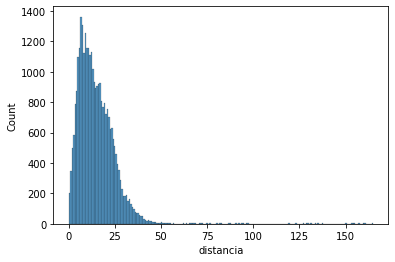

In [58]:
# Histograma da variável distância

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.histplot(data=dfMerged_groupDF,x='distancia')

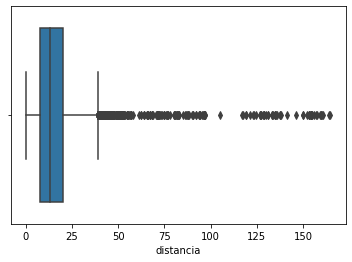

In [59]:
# Boxplot da variável distância

sns.boxplot(x=dfMerged_groupDF["distancia"])

In [60]:
#Limpeza de outliers
dfMerged_groupDF = dfMerged_groupDF[dfMerged_groupDF.distancia <= 100]

In [61]:
dfMerged_groupDF.shape

(31249, 12)

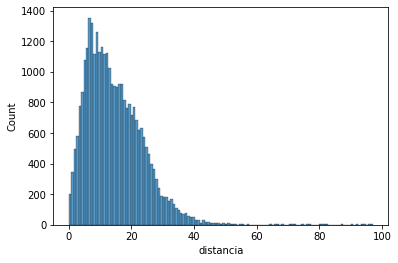

In [62]:
#histograma pós limpeza
sns.histplot(data=dfMerged_groupDF,x='distancia')

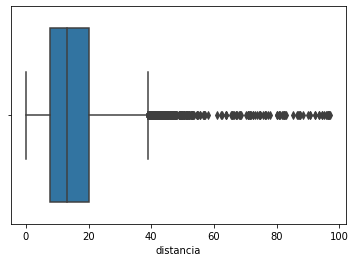

In [63]:
#boxplot pós limpeza

sns.boxplot(x=dfMerged_groupDF["distancia"])

In [64]:
dfMerged_groupDF.distancia.describe()

count    31249.000000
mean        14.669020
std          9.242233
min          0.000000
25%          7.682222
50%         13.042641
75%         20.158877
max         97.151253
Name: distancia, dtype: float64

In [65]:
# Análise dos pontos de vacinação mais cheios

dfUBS_count = dfMerged_group.groupby('id_estabelecimento')['contador'].agg('sum')
dfUBS_count = pd.merge(dfUBS_count,dfPostosDF[['id_estabelecimento','nm_fantasia','lati','long']],on='id_estabelecimento')
dfUBS_count.sort_values(ascending=False,by='contador',inplace=True)
top10UBS = dfUBS_count.head(10)
top10UBS.reset_index(inplace=True,drop=True)
top10UBS


,id_estabelecimento,contador,nm_fantasia,lati,long
0,11150,59965,UBS 01 ASA SUL,-15.822105,-47.891575
1,9056963,42049,UBS 01 VICENTE PIRES,-15.776895,-47.975704
2,7161158,23973,HOSPITAL MILITAR DE AREA DE BRASILIA,-15.789014,-47.938794
3,10723,23476,UBS 2 ASA NORTE,-15.747387,-47.891175
4,11223,20118,UBS 1 SOBRADINHO,-15.669269,-47.802543
5,10626,19994,UBS 05 TAGUATINGA,-15.826566,-48.074543
6,10901,19167,UBS 01 TAGUATINGA,-15.826566,-48.074543
7,11118,18167,UBS 01 GUARA,-15.815299,-47.983879
8,11010,18085,UBS 5 CEILANDIA,-15.807411,-48.105587
9,11614,17898,UBS 5 QUEBRADA DOS NERES,-15.743135,-47.862260


In [66]:
# Criando marcadores

from folium.plugins import MeasureControl

m1 = fl.Map(location=[-15.7751257, -48.0785352],tiles='OpenStreetMap',zoom_control=False)

ubs = fl.FeatureGroup(name='UBS DF - Pontos de vacinação Covid-19')
for i in range(0,len(dfPostosGeo)): 
  fl.Marker([dfPostosGeo.loc[i,'lati'],dfPostosGeo.loc[i,'long']],
  icon=fl.Icon(color='blue'),
  tooltip= dfPostosGeo.loc[i,'nm_fantasia'],
  ).add_to(ubs)
 
top10 = fl.FeatureGroup(name='Pontos de vacinação mais cheios')
for i in range(0,len(top10UBS)):
  fl.Marker([top10UBS.loc[i,'lati'],top10UBS.loc[i,'long']],
  icon=fl.Icon(color='red'),
  tooltip= top10UBS.loc[i,'nm_fantasia'],
  ).add_to(top10)

m1.add_child(ubs)
m1.add_child(top10)
m1.add_child(MeasureControl())
m1.add_child(fl.LatLngPopup())
fl.LayerControl().add_to(m1)

m1.save('mapa.html')

m1

In [ ]:
dfMerged.head()

,paciente_id,id_estabelecimento,data_aplicacao,dose_declarada,id_cidade,id_cep,id_grupo
0,9082347,9509356,2021-03-18,1.0,5300108,72220.0,2.0
4,9082505,11150,2021-01-28,1.0,5300108,73045.0,9.0
6,9082757,9509356,2021-03-18,1.0,5300108,72236.0,2.0
10,9084261,9509356,2021-03-22,1.0,5300108,72235.0,2.0
12,9085000,9768637,2021-03-18,1.0,5300108,73330.0,2.0


In [ ]:
dfCep.head()

,id,id_cep,cidade_id,lat,lon
0,1,1001.0,3550308,-46.634097,-23.550998
1,2,1002.0,3550308,-46.635471,-23.548366
2,3,1003.0,3550308,-46.636392,-23.549012
3,4,1004.0,3550308,-46.634955,-23.549962
4,5,1005.0,3550308,-46.636848,-23.549578


In [ ]:
#Construção do mapa de calor

dfHeat = dfMerged.groupby(['id_cep']).size().reset_index(name='contador')
dfHeat = pd.merge(dfHeat,dfCep[['lat','lon','id_cep']],on='id_cep')
dfHeat.rename(columns={"lat":"lon_resid","lon":"lat_resid"},inplace=True)
plotHeat = dfHeat[['lat_resid','lon_resid','contador']].values.tolist()

m2 = fl.Map(location=[-15.7751257, -48.0785352],tiles='OpenStreetMap',zoom_control=False)

from folium.plugins import HeatMap
heatmap = HeatMap(plotHeat,radius=18).add_to(m2)
heatmap.save('mapa_calor.html')
m2



In [103]:
# Fechando conexão
postgreSQLConnection.close()